In [25]:
import tensorflow as tf
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

#Dataset
#https://www.kaggle.com/noulam/tomato

train_data="G:/Plant Diseases Dataset/train"
test_data="G:/Plant Diseases Dataset/test"

In [59]:
#Creating list of Target Variables
Label_folder=glob('G:/Plant Diseases Dataset/train/*')
Labels=[]
for i in Label_folder:
    i=i.split("\\")[1]
    Labels.append(i)
print("Length of Labels : ",len(Labels))    
print(Labels)

Length of Labels :  10
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [27]:
#Storing image names to display
image_labels=glob('G:\\Plant Diseases Dataset\\train\\Tomato___Bacterial_spot\\*')
images=[]
for i in image_labels:
    i=i.split("\\")[4]
    images.append(i)

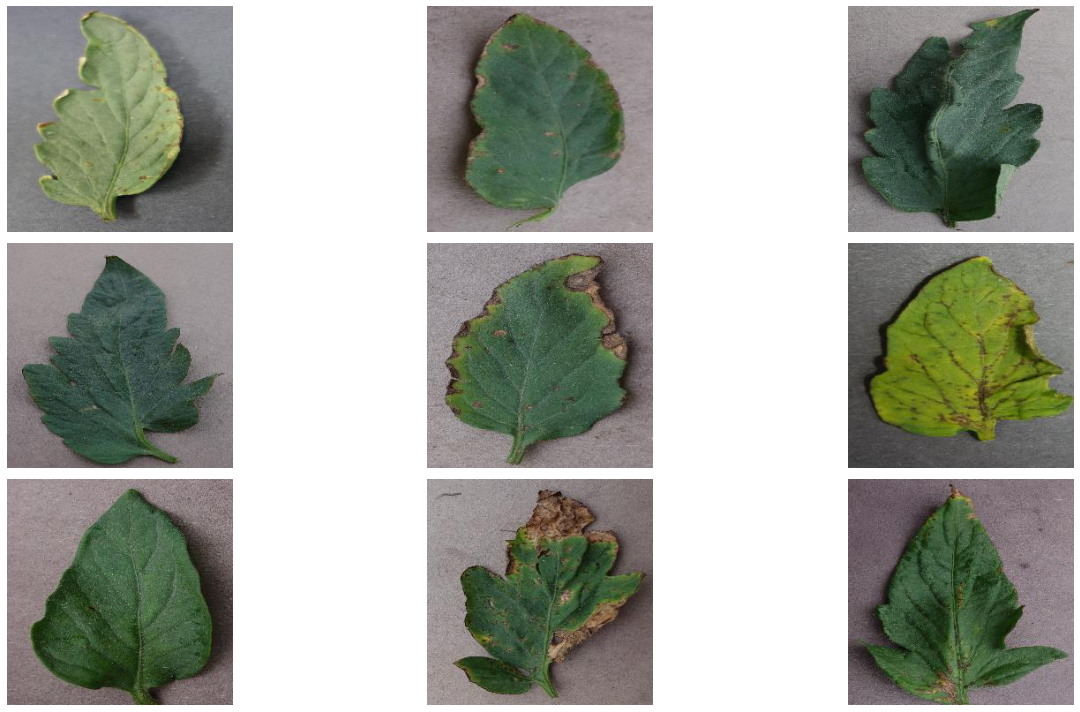

In [71]:
# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'G:\\Plant Diseases Dataset\\train\\Tomato___Bacterial_spot\\'   

# Adjust the size of your images
plt.figure(figsize=(20,10))
# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

#### VGG Network

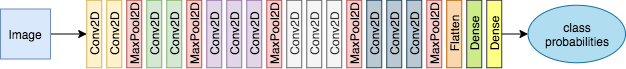

In [39]:
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions
        
        # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
        for i in range(self.repetitions):
            
            # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(self.filters, self.kernel_size,
                                                               activation= 'relu', padding= 'same')
        
        # Define the max pool layer that will be added after the Conv2D blocks
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size, strides=strides)
  
    def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 = vars(self)['conv2D_0']
      
        # Connect the conv2D_0 layer to inputs
        x = conv2D_0(inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1,self.repetitions):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            conv2D_i = vars(self)[f'conv2D_{i}']
          
            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Finally, add the max_pool layer
        max_pool = self.max_pool(x)
      
        return max_pool

In [40]:
class MyVGG(tf.keras.Model):

    def __init__(self, num_classes):
        super(MyVGG, self).__init__()

        # Creating blocks of VGG with the following 
        # (filters, kernel_size, repetitions) configurations
        self.block_a = Block(filters=64, kernel_size=3, repetitions=2)
        self.block_b = Block(filters=128, kernel_size=3, repetitions=2)
        self.block_c = Block(filters=256, kernel_size=3, repetitions=3)
        self.block_d = Block(filters=512, kernel_size=3, repetitions=3)
        self.block_e = Block(filters=512, kernel_size=3, repetitions=3)

        # Classification head
        # Define a Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc = tf.keras.layers.Dense(256, activation='relu')
        # Finally add the softmax classifier using a Dense layer
        self.classifier =tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Chain all the layers one after the other
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.classifier(x)
        return x

In [62]:
# Initialize VGG with the number of classes 
vgg = MyVGG(num_classes=10)

# Compile with losses and metrics
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('G:/Plant Diseases Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                classes=Labels)

test_set = test_datagen.flow_from_directory('G:/Plant Diseases Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [ ]:
# Train the custom VGG model
vgg.fit(training_set, epochs=20)